# Workfile

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedKFold, RepeatedStratifiedKFold
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression

import utils.mining_data_tb as md
import utils.visualization_tb as vi
import utils.models_tb as mo


import warnings

warnings.filterwarnings("ignore")

## Loading and preprocessing data

In [2]:
#### Load data
data_path = "data/hospital_train.csv"
variables_path = "data/columns_meaning.csv"

df = md.load_data(data_path, variables_path)

#### Preprocessing of categorical variables, as saw in 0_analysis file
# Preprocessor object
preprocessor = md.preprocessor()

# Process dummies
df = preprocessor.dummies(df)

# Map to process ordinal variables
to_map = ["Admission Type registered by the Hospital", "Severity of the illness recorded at the time of admission", "Age of the patient", "Stay Days by the patient"]

# Process ordinal variables
df = preprocessor.ordinal_mapper(df, to_map)

# Let's fill the NaNs with the mode an we are ready to go
df.iloc[:, 3] = df.iloc[:, 3].fillna(df.iloc[:, 3].mode()[0])
df.iloc[:, 5] = df.iloc[:, 5].fillna(df.iloc[:, 5].mode()[0])

## Scaling the data

As we have categorical and numerical variablles all together and with different scales, it makes sense to scale the data, at least for the linear models such as Logistic Regression and SVMs. This way we avoid the models to give more weight to some variables due to scale.

RandomForest though probably won't be affected by this.

In [3]:
seed = 42

# Scaler
st_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

# Independent variables
X = np.array(df.drop("Stay Days by the patient", axis = 1))
X_st_scaled = st_scaler.fit_transform(X)
X_mm_scaled = mm_scaler.fit_transform(X)

# Dependent variable
y = np.array(df["Stay Days by the patient"])

## Logistic Regression

Let's try Logistic Regression again using the different scalers

In [9]:
# To train/test the models, I'll make use of a "modeller" class that will take care
# of all the steps and return the main metrics

# Object definition
modeller = mo.modeller(model)

# Data and parameters to pass in to the modeller object
# Train/test data
X_train, X_test, y_train, y_test = train_test_split(X_st_scaled, y, test_size = .2, random_state = seed)
# Cross validation
kfold = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1)
# Data features
features = list(df.columns)
# Model
model = LogisticRegression(max_iter = 1000, n_jobs = -1)

# Now we load the data into the model
modeller.load_data(X_train, X_test, y_train, y_test, features, kfold)

# Finally, we train the model (only in the training set and using cross validation)
modeller.trainer(verb = 2)


-- Model 1 --
-------------------------
>train score: 0.391140625
>validation score: 0.38625
--------------------------------------------------
Set structure:
Train structure: {1: 0.074453125, 2: 0.243984375, 3: 0.273953125, 4: 0.172875, 5: 0.037234375, 6: 0.10990625, 7: 0.00875, 8: 0.0330625, 9: 0.014703125, 10: 0.009046875, 11: 0.02203125}
Validation structure: {1: 0.0744375, 2: 0.244, 3: 0.274, 4: 0.172875, 5: 0.0371875, 6: 0.109875, 7: 0.00875, 8: 0.0330625, 9: 0.0146875, 10: 0.0090625, 11: 0.0220625}
###########################################################################

-- Model 2 --
-------------------------
>train score: 0.391203125
>validation score: 0.3910625
--------------------------------------------------
Set structure:
Train structure: {1: 0.074453125, 2: 0.243984375, 3: 0.273953125, 4: 0.172875, 5: 0.037234375, 6: 0.10990625, 7: 0.00875, 8: 0.0330625, 9: 0.014703125, 10: 0.009046875, 11: 0.02203125}
Validation structure: {1: 0.0744375, 2: 0.244, 3: 0.274, 4: 0.172

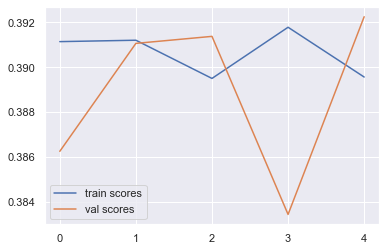

In [11]:
# Let's see the results
plt.plot(modeller.train_scores)
plt.plot(modeller.val_scores)
plt.legend(["train scores", "val scores"])
plt.xticks(range(5))
plt.show()

In [12]:
modeller.tester(verb = 4)

-- Scores --
>Train score: 0.3901
>Test score: 0.3923
--------------------------------------------------
--------------------------------------------------

-- Metrics --
Accuracy: None
Precision: 0.3923
Recall: 0.35396350700793805
F1 score: 0.34527207358084083
--------------------------------------------------

-- Confusion matrix --
[[  59  723  652   33    0    4    0    0    0    0    0]
 [  18 2288 2238  224    0  189    0    0    0    0    0]
 [  16 1584 3686  159    0   87    0    0    0    0    3]
 [  10  692 1457  633    0  675    0    0    0    0   14]
 [   7  170  407   48    0   54    0    0    0    0    4]
 [   5  208  351  589    0 1026    0    0    0    0   13]
 [   0   26   83   21    0   21    0    0    0    0    6]
 [   1   41   67  174    0  304    0    0    0    0   65]
 [   0   17   10   26    0  215    0    0    0    0   26]
 [   0    9   23   31    0   93    0    0    0    0   28]
 [   1   13   25   27    0  167    0    0    0    0  154]]
------------------------

Well, scaling the data really does help the model find the patterns and predict. In fact, now it isn't only predicting two categories, but up to 6!

Out of the two scalers, the StandardScaler() seems to be doing a bit of a better job.

Let's plot the relative confusion matrix to see clearer where the model is doing well or not.

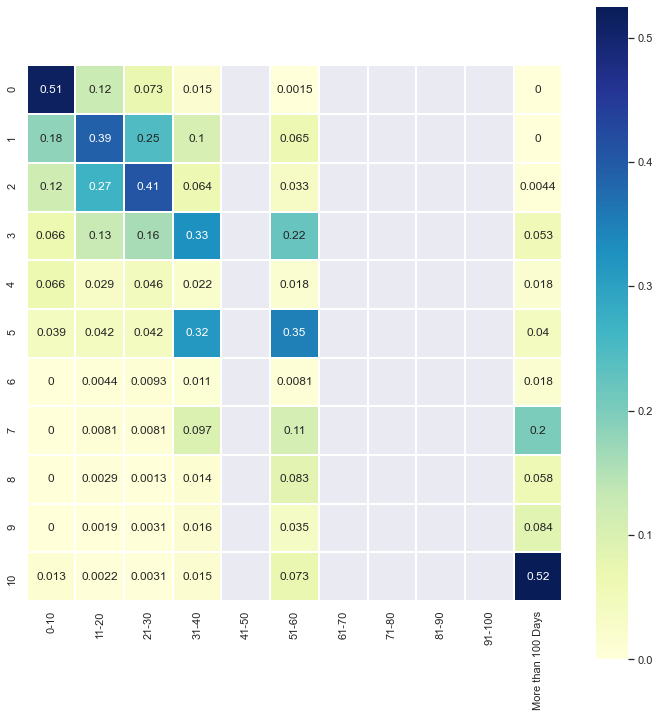

In [7]:
# To calculate the predicitons relative to the column sum
col_sum = modeller.cm.sum(axis = 0, keepdims = True)
col_rel = modeller.cm / col_sum

labels = preprocessor.target_variable()

# To plot
plt.figure(figsize = (12, 12))
sns.heatmap(col_rel, annot = True, linewidths = .1, square=True, cmap = "YlGnBu")

plt.xticks(np.arange(11) + .5, list(labels.values()), rotation = 90)

plt.show()

The model is doing fairly well compared to the based line. However, we can see that it is confusing quite a lot the categories "11-20" and "21-30".

It is also predicting many "51-60" as "31-40".

Let's try with other models now.